# GA Capstone: Topic Modelling on AMD vs Nvidia GPU

## Contents
- Data Extraction
- Data Cleaning
- [EDA](#EDA)
- [Prepare data for LDA modeling](#Prepare-reddit-comments-for-LDA-modeling)
- [Phrase modeling: Bigram and Trigram models](#Phrase-modeling:-Bigram-and-Trigram-models)
- [LDA Model Training](#LDA-Model-Training)
- [LDA Mallet Model](#LDA-Mallet-Model)
- Model creation
- Model Evaluation

# Import the libraries

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from pprint import pprint
import os
from collections import Counter

# Bokeh package for TSNE
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, ColumnDataSource
from bokeh.io import output_notebook

import re
# NLTK Library
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Import PRAW package
import praw
from praw.models import MoreComments

# Gensim library
import gensim
from gensim.utils import simple_preprocess, ClippedCorpus
from gensim.models import LdaMulticore, CoherenceModel, Phrases
from gensim.models.wrappers import LdaMallet
from gensim.models.phrases import Phraser
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora

# pyLDAvis library
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Detect non-english words
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Detect non-english words using spacy
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)


# Import the wordcloud library
from wordcloud import WordCloud

# Removes depreciation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
# Set the max rows and columns for Pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [3]:
# Set the style use
plt.style.use('ggplot')

# Load the dataset

In [4]:
# Read the existing csv file
GPU_df = pd.read_csv('./reddit dataset/cleaned_combined_df.csv')
GPU_df

,Reddit comments,tag
0,pre order time releasing 17th,nvidia
1,going hard grab 3080 17th,nvidia
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia
3,talking spatula jensen pot,nvidia
4,10k core completely insane,nvidia
...,...,...
25511,motherboard say pcie 0 compatible,nvidia
25512,thanks understanding know course 3000s dvi por...,nvidia
25513,buy 1400 gpu,nvidia
25514,know ill wait 3070 3060,nvidia


In [5]:
nvidia_df = GPU_df[GPU_df['tag'] == 'nvidia']
nvidia_df

,Reddit comments,tag
0,pre order time releasing 17th,nvidia
1,going hard grab 3080 17th,nvidia
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia
3,talking spatula jensen pot,nvidia
4,10k core completely insane,nvidia
...,...,...
25511,motherboard say pcie 0 compatible,nvidia
25512,thanks understanding know course 3000s dvi por...,nvidia
25513,buy 1400 gpu,nvidia
25514,know ill wait 3070 3060,nvidia


# Prepare comments for modeling

In [54]:
# Creates the bag of words for each document
data = [token.split() for token in nvidia_df['Reddit comments'].tolist()]

In [55]:
# Prints the bag of words from the first 3 documents
print(data[:3])

[['pre', 'order', 'time', 'releasing', '17th'], ['going', 'hard', 'grab', '3080', '17th'], ['uk', 'price', '3090', '1399', '3080', '649', '3070', '469', 'scan', 'aib', 'card', 'thanks', 'u', 'benzyl', 'chloride', 'overclockers', 'aib', 'card']]


# Phrase modeling: Bigram and Trigram models

In [56]:
# Build the bigram and trigram models
bigram = Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram, this reduces memory, making the model smaller and faster
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [57]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_bigrams = make_bigrams(data)

# Form Trigrams
data_trigrams = make_trigrams(data)

In [58]:
# Create a dictionary to hold the different n-grams dataset
phrase_list = {'unigram': data, 'bigrams': data_bigrams, 'trigrams': data_trigrams}
# phrase_list

# LDA on AMD comments with all the ngrams

In [83]:
# Creating a function to create the LDA model and compute the coherence score
def lda_calculate_coherence_values(ngram_data, num_topics):
    """
    This function calculates the coherence score and the perplexity scores for each ngram and stores
    the model, corpus and the id2word in their respective dictionaries
    """
    model_dict = {}
    score_dict = {}
    for key, value in ngram_data.items():
        ngram_id2word = corpora.Dictionary(value)
        ngram_corpus = [ngram_id2word.doc2bow(text) for text in value]

        ngram_lda_model = LdaMulticore(corpus=ngram_corpus, 
                             id2word=ngram_id2word, 
                             num_topics=num_topics,
                             chunksize=100,
                             passes=20, 
                             random_state=42,
                            per_word_topics=True)


        # Compute Perplexity score
        ngram_perplexity = ngram_lda_model.log_perplexity(ngram_corpus)  # a measure of how good the model is. lower the better.

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=ngram_lda_model, texts=value, dictionary=ngram_id2word, coherence='c_v')
        ngram_coherence_lda = coherence_model_lda.get_coherence()
        
        # Prints out the topics for each ngram
        print('\n\n')
        print(f'*********Displaying {num_topics} topics for {key}******************\n\n')
        pprint(ngram_lda_model.print_topics())
        
        # Store the perplexity and coherence scores in score_dict
        score_dict[key] = []
        score_dict[key].append(ngram_perplexity)
        score_dict[key].append(ngram_coherence_lda)
        
        # Stores the ngram's model, corpus, id2word in model_dict
        model_dict[key] = []
        model_dict[key].append(ngram_lda_model)
        model_dict[key].append(ngram_corpus)
        model_dict[key].append(ngram_id2word)

    return score_dict, model_dict, num_topics

In [84]:
# Calculate using a dictionary
score_dict, model_dict, num_topics = lda_calculate_coherence_values(phrase_list, 5)




*********Displaying 5 topics for unigram******************


[(0,
  '0.019*"amd" + 0.019*"nvidia" + 0.011*"time" + 0.011*"people" + 0.009*"buy" '
  '+ 0.008*"3080" + 0.008*"year" + 0.007*"card" + 0.007*"know" + '
  '0.006*"price"'),
 (1,
  '0.014*"memory" + 0.012*"chip" + 0.009*"3090" + 0.009*"bit" + 0.007*"bus" + '
  '0.005*"video" + 0.004*"benchmark" + 0.004*"gaming" + 0.004*"number" + '
  '0.004*"marketing"'),
 (2,
  '0.013*"core" + 0.012*"3080" + 0.011*"power" + 0.011*"card" + 0.010*"psu" + '
  '0.009*"rtx" + 0.007*"fe" + 0.007*"fan" + 0.007*"case" + 0.007*"3090"'),
 (3,
  '0.022*"3080" + 0.019*"price" + 0.019*"3090" + 0.015*"ti" + 0.012*"people" + '
  '0.011*"card" + 0.009*"series" + 0.009*"2080" + 0.008*"going" + 0.008*"buy"'),
 (4,
  '0.029*"game" + 0.020*"vram" + 0.014*"4k" + 0.010*"1440p" + 0.008*"need" + '
  '0.008*"gpu" + 0.008*"setting" + 0.007*"play" + 0.007*"fps" + 0.007*"ram"')]



*********Displaying 5 topics for bigrams******************


[(0,
  '0.016*"price" + 0.

## Intrepreting the topics for unigram

Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () infers the score

Topic 0 (4)
* Discusses about the purchase of the GPUs

Topic 1 (3)
* Has to do with RTX 3090 and waiting on the GPU's benchmark

Topic 2 (2)
* 3080 and 3090 powersupply required to run the card, compares against fe (Founder's edition), reference cards and aib (AMD / Nvidia's 3rd party manufacturers like MSI, EVGA)

Topic 3 (3)
* The different types of GPUs

Topic 4 (2)
* Different resolutions for the monitor and the relationship with the GPU's video ram (vram)

**2 topics were intrepretable.**

## Interpreting the topics for the bigrams 


Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () is the score

Topic 0 (4)
* Discusses about the consumers waiting to upgrade their gpu

Topic 1 (2)
* Compares price against the 3090 and 3080 against the titan and 2080ti

Topic 2 (1)
* Has to do with 3080 and 3090's fan and psu

Topic 3 (2)
* gaming consoles and their cpu and gpu

Topic 4 (4)
* Different resolutions for the monitor to play the game

**2 topics were intrepretable.**

## Interpreting the topics for the trigrams 


Scored between 1 ~ 5 with regards to their intrepretability, >= 3 will be considered intrepretable.
* () is the score

Topic 0 (4)
* Discusses about the consumers waiting to upgrade their gpu

Topic 1 (1)
* Fitting the GPU into their case (Possibly too big?)

Topic 2 (4)
* Different resolutions and the fps when playing games

Topic 3 (3)
* Different models of GPUs

Topic 4 (1)
* AMD and Nvidia's CPU and gpu price and power

**3 topics were intrepretable.**

In [79]:
topics_interpretable = [2,2,3]

In [80]:
score_df = pd.DataFrame(score_dict).T
score_df.columns = ['Perplexity score', 'Coherence score']
score_df['no of topics intrepretable'] = topics_interpretable
score_df

,Perplexity score,Coherence score,no of topics intrepretable
unigram,-7.831890,0.479104,2
bigrams,-7.889612,0.482577,2
trigrams,-7.875519,0.565147,3


## Summary

Using Coherence score as the main metric and no of topic intrepretable as the secondary metric to select the best ngram, between unigrams and bigrams, I'll be choosing **trigrams** as the it has the larger number of intrepretable topics compared to the other n_grams and it has the **second highest coherence score**.

## Visualizing the topics-keywords

In [92]:
# Obtaining the lda trigram model, corpus and dictionary
lda_trigram_model, trigram_corpus, trigram_id2word = model_dict['trigrams']

In [93]:
# Visualize the topics for the trigram model
pyLDAvis.enable_notebook()
# Creates the filepath to save the html file
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+ 'nvidia_' + 'trigram_' +'ldavis_prepared_'+str(num_topics))

trigram_vis = pyLDAvis.gensim.prepare(lda_trigram_model, trigram_corpus, trigram_id2word)

# Saves the graph as a html file to the LDAvis_data_filepath
pyLDAvis.save_html(trigram_vis, os.getcwd()+ '\\visualization\\' + 'nvidia_' + 'trigram_' + 'ldavis_prepared_'+ str(num_topics) +'.html')

trigram_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.088808  0.059652       1        1  26.598866
3     -0.001410  0.139206       2        1  22.717789
2      0.230121 -0.040339       3        1  21.672441
4     -0.053536  0.033069       4        1  17.320591
1     -0.086368 -0.191588       5        1  11.690313, topic_info=      Term         Freq        Total Category  logprob  loglift
295   game  1193.000000  1193.000000  Default  30.0000  30.0000
10    3090  1455.000000  1455.000000  Default  29.0000  29.0000
211   vram  1066.000000  1066.000000  Default  28.0000  28.0000
35      ti   817.000000   817.000000  Default  27.0000  27.0000
4     3080  1924.000000  1924.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
163    amd    77.969855   701.158808   Topic5  -5.4640  -0.0500
427   need    75.425762   613.325291   Topic5  -5.4972   0.0507
389   know    70.793212   639.285214   Topic5  -5.5606  -0.0542
73     new    64.949701   773.085113   Topic5  -5.6468  -0.3304
280  think    63.387011   783.481893   Topic5  -5.6711  -0.3681

[371 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
92        3  0.891624     0
92        4  0.101729     0
92        5  0.005984     0
194       1  0.130186    10
194       2  0.466249    10
...     ...       ...   ...
227       1  0.579740  year
227       2  0.057364  year
227       3  0.247763  year
227       4  0.073230  year
227       5  0.041497  year

[732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 2])

## Intrepeting the pyLDAvis graph

Topics 1 has the largest bubble which shows the larger percentage of the documents belong to topic 1. Topics 1 and 4 overlap one another, which shows that they have close related to one another. Topic 5 is the furtherest apart from the other topics. The blue bars represent the overall term frequency of the corpus and the red bars represent the term frequency with regards to the topic.

The GPU model terms tend to appear the most often in topic 3. Topic 2 discusses about the different types of resolutions. Topic 4 mainly discusses amd and nividia and amd's CPU and GPU power. Topic 5 discusses about the rtx 3080 and rtx 3090 size and how it fits in their computer casing.

# LDA Mallet Model

Notes:

* Download [link](http://mallet.cs.umass.edu/download.php)
* Need to install [JDK](https://www.oracle.com/java/technologies/javase-jdk15-downloads.html) (Java Development Kit) to make it work
* Need to configure the [PATH file](https://docs.oracle.com/javase/10/install/installation-jdk-and-jre-microsoft-windows-platforms.htm#JSJIG-GUID-96EB3876-8C7A-4A25-9F3A-A2983FEC016A) after installing

Go to *Importing the optimal mallet model pickle file* section if you've not installed the JDK

LDA Mallet model often gives a better quality of topics compared to the LDA. I'll be creating to see if the coherence score is much greater than the LDA and if there's a greater intrepretability in the number of topics.

In [19]:
# Update the environment path
os.environ.update({'MALLET_HOME': r'C:\mallet\mallet-2.0.8'})
mallet_path = r'C:/mallet/mallet-2.0.8/bin/mallet.bat'
# prefix_path = r'C:/mallet/ga_capstone'
mallet_path

'C:/mallet/mallet-2.0.8/bin/mallet.bat'

## Finding the best k topics for the mallet model

In [20]:
# Solution: Follow this
def mallet_compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=4):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    num_topics_list: Number of topics
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    #For two lines below update with your path to new_mallet
#     os.environ.update({'MALLET_HOME':r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet\mallet-2.0.8'})
#     mallet_path = r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet\mallet-2.0.8\bin\mallet.bat'
#     prefix_path = r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet files'
    
    coherence_values = []
    model_list = []
    num_topics_list = []


    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary, random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)

    return model_list, coherence_values, num_topics_list

In [21]:
# Using Bigram as it has the highest coherence value
model_list, coherence_values, num_topics_list = mallet_compute_coherence_values(dictionary=trigram_id2word, all_corpus=trigram_corpus,
                                                                         texts=data_trigrams, start=1, limit=11, step=1)

# Creating the dataframe to hold the model list, coherence values and the number of topics list
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

# Finds the optimal number of topics based on the highest coherence score
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

# Train the model based on the optimal number of topics
optimal_model = LdaMallet(mallet_path, corpus=trigram_corpus, num_topics=optimal_num_topics, id2word=trigram_id2word,
                                                 prefix='nvidia_optimal_', random_seed=42)

In [22]:
model_values_df

,model_list,coherence_values,num_topics
0,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.371841,1
1,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.533103,2
2,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.569926,3
3,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.536058,4
4,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.535934,5
5,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.536693,6
6,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.538344,7
7,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.519279,8
8,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.508902,9
9,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.482650,10


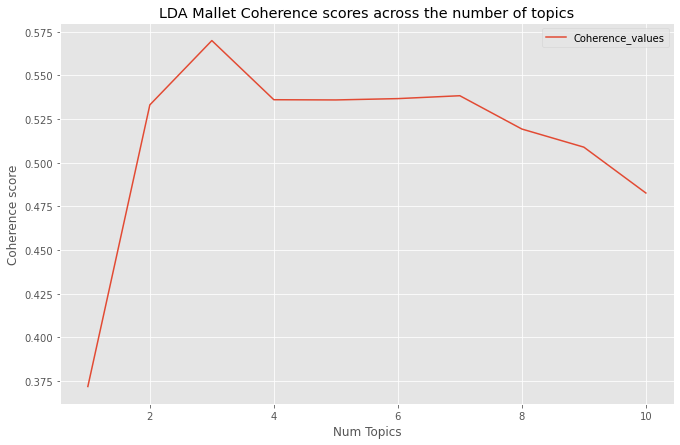

In [91]:
# model_list, coherence_values = compute_coherence_values(dictionary=trigram_id2word, corpus=trigram_corpus, texts=data_trigrams, start=start, limit=limit, step=step)

# Show graph

x = model_values_df['num_topics'].values.tolist()

plt.figure(figsize=(11,7))

plt.plot(x, coherence_values)

plt.title('LDA Mallet Coherence scores across the number of topics')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["Coherence_values"], loc='best')
plt.show()

The coherence score peaks at creating 3 topics before it starts to stagnate and dip. 

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.3718
Num Topics = 2  has Coherence Value of 0.5331
Num Topics = 3  has Coherence Value of 0.5699
Num Topics = 4  has Coherence Value of 0.5361
Num Topics = 5  has Coherence Value of 0.5359
Num Topics = 6  has Coherence Value of 0.5367
Num Topics = 7  has Coherence Value of 0.5383
Num Topics = 8  has Coherence Value of 0.5193
Num Topics = 9  has Coherence Value of 0.5089
Num Topics = 10  has Coherence Value of 0.4826


Viewing the topics and checking if they make sense helps to decide how many topics is the optimal value. I'll be intrepreting the 3 and 4th topic.

## Exporting the optimal model to pickle file

In [25]:
# Save to file in the current working directory
# Exporting the optimal model

pkl_filename = "./models/nvidia_optimal_ldamallet_model.pkl"
out_file = open(pkl_filename, 'wb')
pickle.dump(optimal_model, out_file)
out_file.close()

## Exporting the 2 topics trained model to pickle file

In [86]:
# Save to file in the current working directory
# Exporting the optimal model

pkl_filename = "./models/nvidia_2_topics_ldamallet_model.pkl"
out_file = open(pkl_filename, 'wb')
pickle.dump(model_values_df['model_list'][1], out_file)
out_file.close()

## Importing the optimal mallet model pickle file

In [27]:
# pkl_filename = "./models/nvidia_optimal_ldamallet_model.pkl"
# infile = open(pkl_filename,'rb')
# optimal_model = pickle.load(infile)
# infile.close()

In [28]:
# optimal_model

## Importing the 2 topics mallet model pickle file

In [89]:
pkl_filename = "./models/nvidia_2_topics_ldamallet_model.pkl"
infile = open(pkl_filename,'rb')
topic_2_ldamallet = pickle.load(infile)
infile.close()

In [30]:
# topic_5_ldamallet 

## Displaying topics for the optimal model (3 topics)

In [85]:
pprint(optimal_model.show_topics(formatted=False))

[(0,
  [('3080', 0.04898901098901099),
   ('3090', 0.03637362637362637),
   ('ti', 0.01876923076923077),
   ('amd', 0.01567032967032967),
   ('3070', 0.015274725274725275),
   ('rtx', 0.014351648351648351),
   ('2080', 0.012153846153846154),
   ('upgrade', 0.011604395604395605),
   ('2080ti', 0.01123076923076923),
   ('wait', 0.01120879120879121)]),
 (1,
  [('price', 0.026140252089920733),
   ('card', 0.026096937670550525),
   ('nvidia', 0.0249274483475549),
   ('people', 0.02434270368605709),
   ('time', 0.01890674405509594),
   ('buy', 0.01728245332871313),
   ('money', 0.009009399229003335),
   ('series', 0.008814484341837398),
   ('release', 0.008597912244986357),
   ('day', 0.008013167583488544)]),
 (2,
  [('game', 0.02716178979136596),
   ('vram', 0.023662686436600622),
   ('gpu', 0.014390062546472467),
   ('4k', 0.01325285395617373),
   ('year', 0.010737873419936142),
   ('1440p', 0.010562918252197875),
   ('gaming', 0.010453571272361458),
   ('good', 0.01034422429252504),
   ('

## Interpreting the 3 topics 

Topic 0
* Different models of GPU

Topic 1
* Price related during launch day

Topic 2
* Different resolutions: 1440p, 4K

## Displaying 2 topics

In [90]:
pprint(topic_2_ldamallet.show_topics(formatted=False))

[(0,
  [('3080', 0.0321826135920648),
   ('3090', 0.023895121352564934),
   ('game', 0.017932169619266254),
   ('vram', 0.015622067252855143),
   ('ti', 0.012330171380719308),
   ('gpu', 0.010843042982342154),
   ('3070', 0.010034507154098265),
   ('rtx', 0.00942810528291535),
   ('4k', 0.008749512712782084),
   ('2080', 0.007984291303908405)]),
 (1,
  [('price', 0.017713790927369053),
   ('card', 0.01768443916112652),
   ('nvidia', 0.016891941472578113),
   ('people', 0.016495692628303908),
   ('time', 0.012812045964865936),
   ('buy', 0.011711354730770925),
   ('amd', 0.010463904665463245),
   ('good', 0.009480620496338367),
   ('wait', 0.009260482249519366),
   ('money', 0.0062812779759022)])]


## Interpreting the 2 topics 

Topic 0
* Different gpu models

Topic 1
* Stock availability

As I find the 3 topics to be the most intrepretable as well as it's one of the highest coherence score among the other models, I'll be selecting to it to move forward with the project.

# Finding the dominant topic in each sentence

I would like to investigate the dominant topics for the documents and see if it makes sense.

In [94]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for _, row in enumerate(ldamodel[corpus]): # ldamodel[corpus] --> Provides a list of the probability values of which topic a document belongs to
        row = sorted(row, key=lambda x: (x[1]), reverse=True) # Sorts the probabilities of a document is descending order
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic (As it's sorted in descending order, the highest probability is the first topic which is index 0)
                wp = ldamodel.show_topic(topic_num) # Obtain the dominant topic for the document
                topic_keywords = ", ".join([word for word, prop in wp]) # Gets the topic keys words for the topic
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

Notes: The last model trained **must match** with the last optimal_file_doctopics text file. If not, there will be an error message.

In [34]:
# Retrain the model if you've have not done so
# optimal_num_topics = 6
# optimal_model = LdaMallet(mallet_path, corpus=trigram_corpus, num_topics=optimal_num_topics, id2word=trigram_id2word,
#                                                  prefix='optimal_', random_seed=42)

In [95]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=trigram_corpus, texts=data_trigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Document
0,0,1.0,0.3827,"price, card, nvidia, people, time, buy, money,...","[pre_order, time, releasing, 17th]"
1,1,1.0,0.3642,"price, card, nvidia, people, time, buy, money,...","[going, hard, grab, 3080, 17th]"
2,2,1.0,0.4343,"price, card, nvidia, people, time, buy, money,...","[uk, price, 3090, 1399, 3080, 649, 3070, 469, ..."
3,3,0.0,0.3457,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[talking, spatula, jensen, pot]"
4,4,0.0,0.3395,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[10k, core, completely, insane]"
5,5,0.0,0.3512,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[rip, 2080, ti, resale_value, x200b, cry]"
6,6,0.0,0.4159,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[shit, 3070, actually, better, value, people, ..."
7,7,1.0,0.3568,"price, card, nvidia, people, time, buy, money,...","[send, money]"
8,8,0.0,0.4740,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[question, nvidia, 3xxx, series, page, reporti..."
9,9,0.0,0.3690,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[3070, perform, better, 2080ti, price, holy, f..."


In [124]:
# Sort the dataframe in ascending order by the topic percentage contribution
df_dominant_topic_sorted = df_dominant_topic.sort_values('Topic_Perc_Contrib', ascending=False)
idx = np.random.randint(df_dominant_topic_sorted.shape[0])
# idx = 250
document = df_dominant_topic_sorted[['Document']].iloc[idx].values
dominant_topic = df_dominant_topic_sorted[['Dominant_Topic']].iloc[idx].values
dominant_keywords = df_dominant_topic_sorted[['Keywords']].iloc[idx].values

In [125]:
print(f'Dominant keywords: {dominant_keywords} \n\nDocument:{document}')

Dominant keywords: ['game, vram, gpu, 4k, year, 1440p, gaming, good, high, pc'] 

Document:[list(['ah', 'realize', 'purpose', 'pc', 'play', 'game', 'absolutely', 'want', 'game', 'dirt', 'cheap', 'console', 'look', 'sony', 'microsoft', 'get', 'discount', 'mass', 'order', 'hardware', 'loss', 'ps5', 'xbox', 'sale', 'going', 'build', 'equivalent', 'pc', 'price', 'thinking', 'nvidia', 'amd', 'hell', 'lower', 'price', 'pipedream', 'economically', 'possible'])]


# Find the most representative document for each topic

In [103]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format the columns
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6234,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...","[3090, simply, titan, titan, driver, basically..."
1,1.0,0.7326,"price, card, nvidia, people, time, buy, money,...","[edit, opinion, x200b, know, teaser_rate, car,..."
2,2.0,0.6444,"game, vram, gpu, 4k, year, 1440p, gaming, good...","[plenty, depends, singeplayer, multiplayer, ba..."


## Most representative document for Topic 0

In [104]:
# Create a helper function to display the most representative documents for a topic
def display_representative_document(topic_n, df):
    dominant_keywords = df['Keywords'].loc[topic_n]
    document_topic = " ".join(df['Representative Text'].loc[topic_n])
    
    print(f'*******Topic {topic_n}********\n\nDominant keywords: {dominant_keywords} \n\nDocument:{document_topic}')

In [105]:
display_representative_document(0, sent_topics_sorteddf_mallet)

*******Topic 0********

Dominant keywords: 3080, 3090, ti, amd, 3070, rtx, 2080, upgrade, 2080ti, wait 

Document:3090 simply titan titan driver basically titan mind 2080 ti increase vram 1080 ti previous gen doubled respectively x70 class 8gb 1070 previously doubling gen prior 28gb 570 2gb 670 2gb 770 680 rebrand 4gb 970 8gb 1070 staying 8gb similarly x80 class doubled gen staying 8gb 1080 2080 receiving minor capacity upgrade 10gb 3080 supposed believe 10gb 3080 upgrade path 11gb 2080 ti compute 3090 titan driver actual titan


The document talks about the price and performance of AMD's 6800xt and 6900xt which fits the topic of the `price` and `performance` of the card.

## Most representative document for Topic 1

In [106]:
display_representative_document(1, sent_topics_sorteddf_mallet)

*******Topic 1********

Dominant keywords: price, card, nvidia, people, time, buy, money, series, release, day 

Document:edit opinion x200b know teaser_rate car advertised insanely price dealership told sold cost little 699 3080 teaser_rate nvidia hyped insanely hint 3080 wanted insanely cheap price announced wanted problem nvidia stock 3080 place retailer stock place know run merchandise tracking system retailer nvidia hype knowing stock satisfy basic demand release day come nvidia counted bot ebay taking 3080 actually available blame bot nvidia overselling hype delivering card bot responsible retailer nvidia hype train knew sufficient stock satisfy basic demand retailer scam seriously believe retailer know stock send 14 99 deliver moon someday guarantee 1000 year offer valid entire universe send money backlash swift betting nvidia shat pant reading forum pissed consumer oh look pre_order delivery october november soon december year nvidia placate consumer come hey worse ussr ordered

The document does not make sense as it's talking about HTML syntaxes which the model poorly interpreted.

## Most representative document for Topic 2

In [107]:
display_representative_document(2, sent_topics_sorteddf_mallet)

*******Topic 2********

Dominant keywords: game, vram, gpu, 4k, year, 1440p, gaming, good, high, pc 

Document:plenty depends singeplayer multiplayer battle royale dog obviously apex legend br duty sp mp br battlefield sp mp br counterstrike mp pubg br doom sp mp rainbow 6 siege mp wolfenstein sp mp fortnite br outlier borderland looter shooter warframe space ninja looter shooter ton grind left dead want shoot zombie deep rock galactic coop experience hardcore simulation shooter arma squad insurgency


The document discusses about [ray tracing](https://www.techradar.com/news/ray-tracing) which gives more lifelike shadows and reflections, along with much-improved translucence and scattering in games. This fits the topic in which it has the keyword `ray_tracing`, `performance`.

# Topic distribution across documents

In [109]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts().sort_index()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num = pd.Series(sorted(df_topic_sents_keywords['Dominant_Topic'].unique()))
topic_keywords = sent_topics_sorteddf_mallet['Keywords']

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num, topic_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(6)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...",4182,0.3805
1.0,1.0,"price, card, nvidia, people, time, buy, money,...",3804,0.3461
2.0,2.0,"game, vram, gpu, 4k, year, 1440p, gaming, good...",3004,0.2733


In [110]:
# Sort the Percentage of documents in descending order
df_dominant_topics.sort_values(by='Perc_Documents', ascending=False)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"3080, 3090, ti, amd, 3070, rtx, 2080, upgrade,...",4182,0.3805
1.0,1.0,"price, card, nvidia, people, time, buy, money,...",3804,0.3461
2.0,2.0,"game, vram, gpu, 4k, year, 1440p, gaming, good...",3004,0.2733


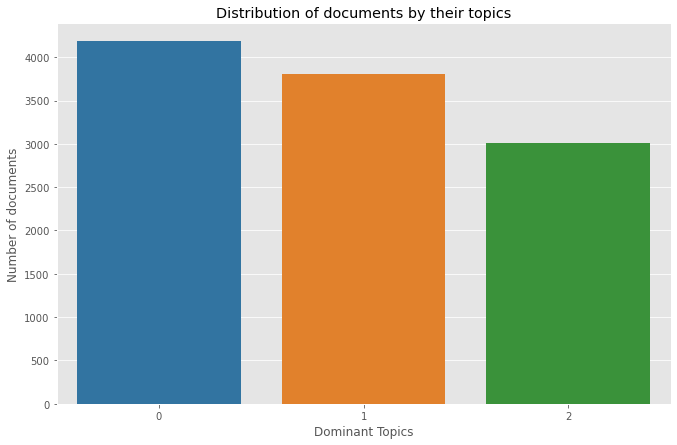

In [115]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

plt.figure(figsize=(11,7))
sns.barplot(x='Dominant_Topic', y='Num_Documents',data=df_dominant_topics, palette=cols)

plt.title('Distribution of documents by their topics')
plt.xticks(np.arange(3),[x for x in range(3)])
plt.xlabel('Dominant Topics')
plt.ylabel('Number of documents');

Topic 3 has the been assigned the most often to the documents with close to 3000 documents being assigned while making up 20% of the topics assigned.
Stock availability during the launch of the GPUs is the most discussed for the AMD's subreddit with Topic 4 coming in second, which goes into comparing the price and performance of the AMD and Nvidia's GPUs. 

The least discussed is Topic 5 which discusses about the [RDNA 2 GPUs](https://www.pcworld.com/article/3528861/what-the-new-xbox-series-x-specs-tell-us-about-nvidias-next-gen-radeon-graphics-cards.html) powering the new gaming consoles, Xbox X series and the PS5. It seems that most of the subreddit users are PC gamers given the least number of Topic 5 documents.

# Frequency Distribution of Word Counts in Documents by dominant topic

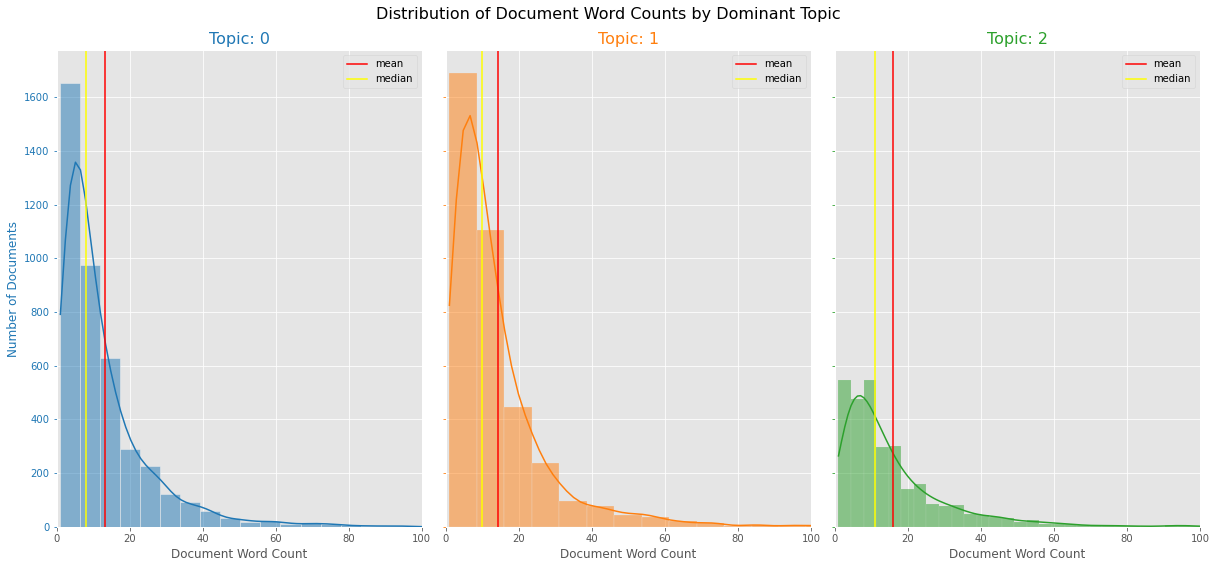

In [133]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

fig, axes = plt.subplots(1,3, figsize=(17,8), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i]
    doc_lens = df_dominant_topic_sub.Document.map(lambda token: len(token)).tolist()
    #ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.histplot(doc_lens, bins=50, color=cols[i], kde=True, ax=ax) # ax.twinx()
    # Mean
    ax.axvline(np.mean(doc_lens), color='red', label='mean')
    # Median
    ax.axvline(np.median(doc_lens), color='yellow', label='median')
    ax.legend()
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

# fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,375,9))
plt.xlim(0,100)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=16)
plt.tight_layout()
plt.show()

All of the distributions shows a right tailed skewed graph in which the mean and median are quite close.

# Word Clouds of Top N Keywords in Each Topic

In [134]:
stop_words = set(STOPWORDS).union(stopwords.words("english")) # Combines gensim stopwords and nltk's stopwords
stop_words = stop_words.union(['http', 'www', 'youtube' 'get', 'like', '1', '2', '3', '5', 'got'])

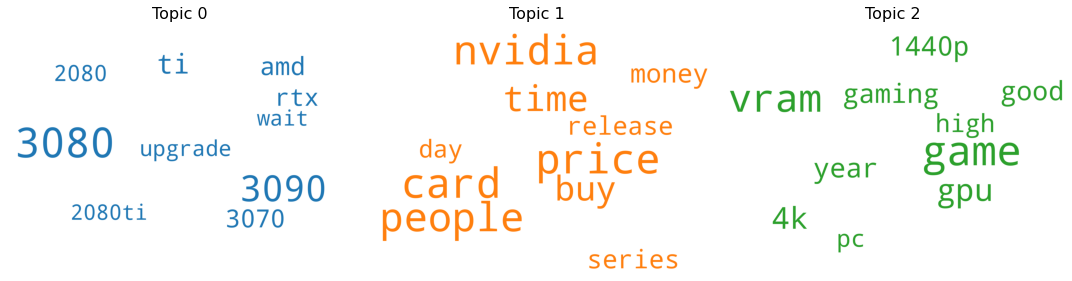

In [136]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

In [137]:
data_flat = [word for word_lst in data_trigrams for word in word_lst] # Creates a list of words 
counter = Counter(data_flat) # Counts the frequency of the tokens and stores in a dictionary
counter

Counter({'pre_order': 58,
         'time': 873,
         'releasing': 48,
         '17th': 61,
         'going': 879,
         'hard': 167,
         'grab': 36,
         '3080': 2229,
         'uk': 63,
         'price': 1208,
         '3090': 1655,
         '1399': 11,
         '649': 12,
         '3070': 695,
         '469': 3,
         'scan': 24,
         'aib': 195,
         'card': 1205,
         'thanks': 184,
         'u': 53,
         'benzyl': 1,
         'chloride': 1,
         'overclockers': 16,
         'talking': 134,
         'spatula': 3,
         'jensen': 32,
         'pot': 1,
         '10k': 18,
         'core': 165,
         'completely': 63,
         'insane': 80,
         'rip': 27,
         '2080': 553,
         'ti': 854,
         'resale_value': 8,
         'x200b': 91,
         'cry': 24,
         'shit': 190,
         'actually': 427,
         'better': 633,
         'value': 158,
         'people': 1124,
         'expected': 47,
         'expensive': 144,


In [138]:
out = [[word, i , weight, counter[word]] for i, topic in topics for word, weight in topic]
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
df.head()

,word,topic_id,importance,word_count
0,3080,0,0.048989,2229
1,3090,0,0.036374,1655
2,ti,0,0.018769,854
3,amd,0,0.015670,713
4,3070,0,0.015275,695


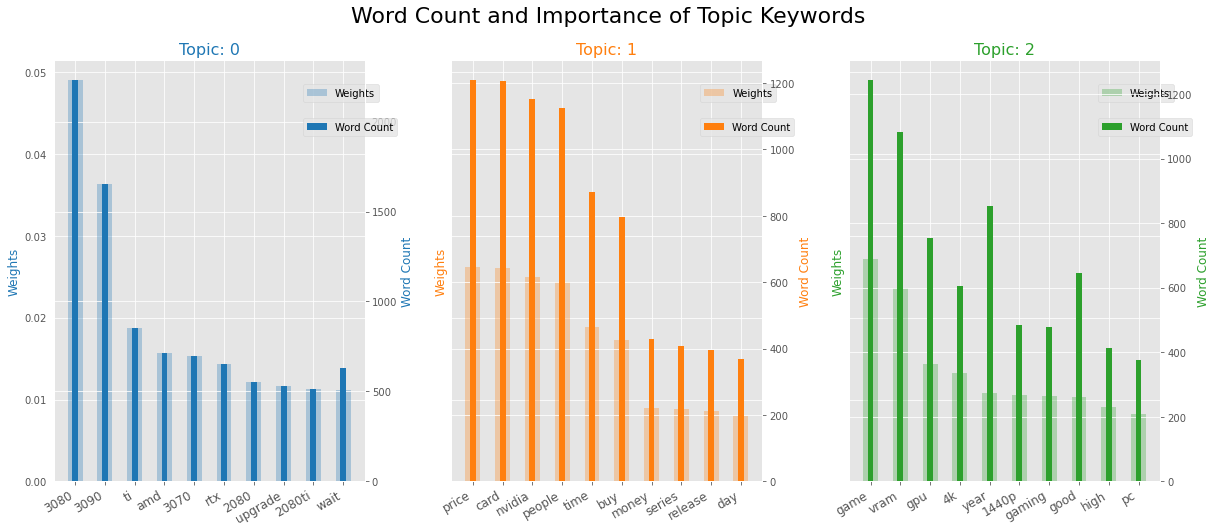

In [144]:
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, 3, figsize=(17,7), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Weights')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Word Count')
    ax.set_ylabel('Weights', color=cols[i])
    ax_twin.set_ylabel('Word Count', color=cols[i])
    # Sets the ylimits for the axes
    #ax_twin.set_ylim(0, 0.030)
    #ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'].tolist(), rotation=30, horizontalalignment= 'right', fontsize=12)
    ax_twin.legend(loc=[0.80,0.82])
    ax.legend(loc=[0.80,0.90])
    

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

### Intrepreting the topic word frequency and their weights

Topic 0:
* Equally distributed weights
* The frequency of the words have little correlation with the weights

Topic 1:
* Equally distributed weights
* nvidia has the highest word frequency
* gpu is more favoured to gpus

Topic 2:
* Performance has the highest frequency, but the weights are not that high
* Gaming features: dlss has a higher weight and frequency compared to ray_tracing, which possibly means a more favoured feature among gamers.
* Resolution: Surprisingly, 4k resolution has a higher frequency and weight compared to 1440p resolution, which is not so main stream yet. 1440p resolution is reaching mainstream crowd.

Topic 3:
* Relating to GPU purchase during the launch
* card seems to appear often, possibly could include in the stopwords
* lol, yeah seems to make little sense here, could add to stopwords

Topic 4:
* The GPU models have a relatively higher word count compared to their frequency
* Nvidia's RTX 3070 and 3080 seems to be favoured over the other GPU models

Topic 5:
* Compared to the other topics, the weights are equal to or higher than their word count.
* good and great share a similar meaning, could potentially add one of the to stopwords.

# Most discussed topics in the documents (Possibly remove)

Note: It'll take **more than an hour** to run if all the documents are added.

In [ ]:
# Sentence Coloring of N Sentences
# def topics_per_document(model, corpus, start=0, end=1):
#     corpus_sel = corpus[start:end] # Obtain a slice of nth documents
#     dominant_topics = []
#     topic_percentages = []
#     for i, corp in enumerate(corpus_sel): # For each document
#         doc = model[corp] # Gets the nth document
#         dominant_topic, topic_percs = sorted(doc, key = lambda x: x[1], reverse=True)[0] # Gets the dominant topic and topic percentage by sorting the topic percentage prob in descending order
#         dominant_topics.append((i, dominant_topic))
#         topic_percentages.append(topic_percs)
#     return(dominant_topics, topic_percentages)

# dominant_topics, topic_percentages = topics_per_document(model=optimal_model, corpus=trigram_corpus, end=10)  

In [ ]:
# Distribution of Dominant Topics in Each Document
# df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
# dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
# df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
# topic_weightage_by_doc = pd.DataFrame([{t} for t in topic_percentages])
# df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
# topic_top3words = [(i, topic) for i, topics in optimal_model.show_topics(formatted=False) 
#                                  for j, (topic, wt) in enumerate(topics) if j < 3]

# df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
# df_top3words = df_top3words_stacked.groupby('topic_id').agg(', '.join)
# df_top3words.reset_index(level=0,inplace=True)

In [ ]:
# df_top3words

In [ ]:
# from matplotlib.ticker import FuncFormatter

# # Plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# # Topic Distribution by Dominant Topics
# ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
# ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
# tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
# ax1.xaxis.set_major_formatter(tick_formatter)
# ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
# ax1.set_ylabel('Number of Documents')
# ax1.set_ylim(0, 1000)

# # Topic Distribution by Topic Weights
# ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
# ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
# ax2.xaxis.set_major_formatter(tick_formatter)
# ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

# plt.show()

# t-SNE Clustering Chart

In [ ]:
# Get topic weights
topic_weights = []

for row_lst in optimal_model[trigram_corpus]:
    lst = []
    for topic_id, topic_perc in row_lst:
        lst.append(topic_perc)
    topic_weights.append(lst)
    

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, perplexity=30, verbose=1, random_state=42, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 3
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
lgd_label = np.array(['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'])

source = ColumnDataSource(dict(
    x=tsne_lda[:,0],
    y=tsne_lda[:,1],
    color=mycolors[topic_num],
    label=lgd_label[topic_num],
))

plot.scatter(x='x', y='y', color='color', source=source)
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8559 samples in 0.007s...
[t-SNE] Computed neighbors for 8559 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8559
[t-SNE] Computed conditional probabilities for sample 2000 / 8559
[t-SNE] Computed conditional probabilities for sample 3000 / 8559
[t-SNE] Computed conditional probabilities for sample 4000 / 8559
[t-SNE] Computed conditional probabilities for sample 5000 / 8559
[t-SNE] Computed conditional probabilities for sample 6000 / 8559
[t-SNE] Computed conditional probabilities for sample 7000 / 8559
[t-SNE] Computed conditional probabilities for sample 8000 / 8559
[t-SNE] Computed conditional probabilities for sample 8559 / 8559
[t-SNE] Mean sigma: 0.000000


t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised non-linear learning technique used for data exploration and visualizing higher dimensional data. It gives a sense of how the data is arranged in a high dimensional-space. As t-SNE preserves small pairwise compared to Principal Component Analysis (PCA), we can see that the Topic 0, 2, 4 and 5 are close together which shows their relationship

# pyLDAVis

In [146]:
# Visualize the topics for the trigram model
pyLDAvis.enable_notebook()
# Creates the filepath to save the html file
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+ 'nvidia_' + 'trigram_' +'mallet_ldavis_prepared_'+str(num_topics))

optimal_model_lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
trigram_mallet_vis = pyLDAvis.gensim.prepare(optimal_model_lda, trigram_corpus, trigram_id2word)

# Saves the graph as a html file to the LDAvis_data_filepath
pyLDAvis.save_html(trigram_mallet_vis, os.getcwd()+ '\\visualization\\' + 'nvidia_' + 'trigram_' + 'mallet_ldavis_prepared_'+ str(num_topics) +'.html')
trigram_mallet_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.099948 -0.365020       1        1  33.622151
1     -0.275786  0.266505       2        1  33.374003
0      0.375734  0.098515       3        1  33.003845, topic_info=       Term         Freq        Total Category  logprob  loglift
4      3080  2545.000000  2545.000000  Default  30.0000  30.0000
10     3090  1889.000000  1889.000000  Default  29.0000  29.0000
295    game  1437.000000  1437.000000  Default  28.0000  28.0000
15     card  1371.000000  1371.000000  Default  27.0000  27.0000
18    price  1374.000000  1374.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
714     8gb   245.524963   245.524963   Topic3  -5.3548   1.1085
266   guess   230.679267   230.679267   Topic3  -5.4172   1.1085
937  reason   229.537291   229.537291   Topic3  -5.4222   1.1085
134    wait   582.408051   720.097361   Topic3  -4.4911   0.8963
194      10   262.654611   405.041974   Topic3  -5.2874   0.6754

[219 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1870      2  1.010609           000
194       1  0.350581            10
194       3  0.649315            10
803       1  0.998409           100
7722      3  0.875675        100kgs
263       3  1.000771          1080
277       1  1.001118         1080p
195       3  1.000771        1080ti
721       3  0.999982          10gb
575       1  0.999766         1440p
7807      1  0.863841           155
7820      1  0.863841         170mm
213       3  0.998337            20
31        3  1.000771          2080
81        3  1.000771        2080ti
7748      1  0.863841      20series
2014      2  0.966669       24_hour
7808      1  0.863841      285x112x
493       2  0.999848            30
9         3  1.000411          3070
4         3  0.999817          3080
196       3  0.999838        3080ti
7850      1  0.863841           309
10        3  1.000015          3090
7788      3  0.875675          3100
7810      1  0.863841  318x121x58mm
7720      3  0.875675          33cm
7749      3  0.875675        3dmark
812       1  1.001118             4
7851      1  0.863841          49mm
450       1  1.000687            4k
7754      3  0.875675          50kw
1942      2  0.995962          550w
7728      3  0.875675         5ft10
7762      1  0.863841          65in
714       3  1.001935           8gb
7757      3  0.875675       abysmal
13        2  1.000469           aib
7798      3  0.875675       aligned
163       3  0.999718           amd
7752      3  0.875675          aqui
7812      1  0.863841         armor
1958      2  1.038570          asap
7723      3  0.875675       barbell
7750      3  0.875675           bbc
7741      1  0.863841      behemoth
284       3  1.001208     benchmark
228       3  1.001831           big
7780      1  0.863841        biguer
108       3  0.998762           bit
7779      1  0.863841   bodybuilder
2022      2  1.002256           bot
130       2  0.999848        bought
7782      1  0.863841         brace
345       2  0.999927           buy
285       2  0.999482        buying
1950      2  0.995962     cancelled
15        2  0.999852          card
259       3  0.999009          case
1946      2  1.038570          clue
2003      2  1.013989          code
327       1  1.001270       console
5073      2  1.054548        corona
581       2  1.000767          cost
7745      1  0.863841      costlier
7732      3  1.050810   counterpart
457       3  0.999167           cpu
639       2  0.999921           day
7835      1  0.863841      deflects
1968      2  1.017546      delivery
1032      1  0.998702    difference
167       1  0.999816            dl
1195      1  0.998526        driver
525       1  0.287149           end
525       2  0.712651           end
1951      2  1.013989      familiar
232       3  1.000197           fan
169       3  0.998402     

The bubbles are spread further apart compared to the LDA's pyLDAvis with the exception of topic 3 and 4. This shows that the topics are distinguishable from one another. Also, it seems that the bubbles are of similar sizes which means that the documents are evenly distributed across the topics.